<center>

<h1>Simulating the Milky Way</h1>

</center>

## Introduction

The goal here is to test the *tree code* and the different integration methods by using it on our galaxy. Why is that interesting you ask? Well, if we have issues with momentum or energy conservation, we should see it in our little simulation.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import os
while not os.path.exists('files'):
    os.chdir('..')
print("Current working directory:", os.getcwd())

Current working directory: /home/kiwi/documents/zurich/compastro


___

### 1. Initial distribution


We need to define the initial positions and velocities of our particles. But let's start with more general parameters.

### 1.1. Simulation Parameters

- $N_{{particles}} < 50000$ is the number of particles in our simulation. More than $50000$ becomes very time consuming.
- $N_{{save}} < 1000 $ is the number of particles that we save at each time step. More would be memory consuming. $1000$ should be enough to sample the distribution.
- $N_{iter} = 1000$ the number of time steps. This will bring us near the relaxation time scale.
- $dt = t_{cross} / 50$ is the time step. It has to be much lower than $t_{cross}$ for accuracy. 
- $R_{Milky \ Way} = 15 \ \text{kpc}$ is the appxorimate radius of the Galaxy. In our simulation, we will choose distance units such that $R=1$.
- $M_{MW} = 1.15 \times 10^{12} M_{\odot}$ the total mass of the Milky Way.
- $z_0 = 0.3 \ \text{kpc}$ is the thickness of the disk.
- $\epsilon = 10^{-3} \times R_{MW}$ the softening length: small compared to the radius to ensure that we do not loose too much accuracy.

In [3]:
N_part = 1000
N_save = 1000
N_iter = 1000

# !-- Units --! #

G = 1
M_tot = 1 # units of 10^12 M_solar
R = 1
m = M_tot / N_part
z0 = 0.3 / 15 # units of 15kpc
eps = R * 0.01
# !-- Time Scales --! #
t_cross = np.sqrt(R**3 / (G * M_tot))
dt = t_cross / 50
t_relax = N_part / (8 * np.log(R / eps) * t_cross) if eps > 0 else 0


print("Softening Length: ", eps)
print("Crossing Time: ", t_cross)
print("Time step: ", dt)
print("Duration of the simulation: ", N_iter * dt)
print("Relaxation Time: ", t_relax)
print("Thicknes of the disk: ", z0)


Softening Length:  0.01
Crossing Time:  1.0
Time step:  0.02
Duration of the simulation:  20.0
Relaxation Time:  27.143405118953243
Thicknes of the disk:  0.02


### 1.2. Exponential Disk Model

We choose the following density profile:

$$
\rho(r, z) = \rho_0 \exp \left(-\frac{r}{R_{MW}} \right) \exp \left(-\frac{|z|}{z_0} \right) 
$$

with $r = \sqrt{x^2 + y^2}$ and $\rho_0$ the central density.

The **surface density** in the plane $z=0$ is thus:
$$
\Sigma (r) = \int_{- \infty}^{\infty} \rho(r,z)dz = 2 \rho_0 z_0 \exp \left(-\frac{r}{R_{MW}} \right)
$$

In the following, we do everything as if the disk was completely flat. This is probably a good approximation, since its thickness is only about $1\%$ of its radius. However, we might encounter some issues in the center of the galaxy, where the distance from the center is not greater than the thickness of the disk. By integrating of the disk of radius $r$, one obtains the cumulative mass:
$$
M(r) = M_{tot} \left[ 1 - \left( 1 + \frac{r}{R_{MW}}\right)e^{-r/R_{MW}} \right]
$$

with $M_{tot} = 4 \pi \rho_0 z_0 R_{MW}^2$.

Thanks to this, we know what value to give to the initial velocity so that the galaxy doesn't collapse on itself. The circular velocity should be:
$$
v_c(r) = \sqrt{\frac{GM(r)}{r}}
$$

If you include some softening $\epsilon$ however, this relation becomes:
$$
v_c(r) = \sqrt{\frac{GM(r) r^2}{(r^2 + \epsilon^2)^{3/2}}}
$$

### 1.3. Super Massive Black Hole

If you simulate the galaxy just like this, it explodes. The trick to get it working, is to put a supermassive black hole in the center of the galaxy. The first question is then: how massive should it be? Well, for the Milky Way, it is about $10^-6$ of the total mass, which might not be enough to ensure stability. However, we can consider smaller galaxies where it amounts to $0.1\% - 1\%$ of the total mass.

Now, how should we add this black hole? Well, we will simply add it in the middle and remove all particles inside its radius. How should we update the theoretical cumulative mass then?
$$
M^{smbh}(r) = M^{smbh} + M(r) - M(R^{smbh})
$$

Adding the SMBH will improve the stability of the simulation greatly!

In [4]:
M_smbh = 5 * M_tot
R_smbh = 0.5 * R

small_r_circ_vel = np.sqrt(G * M_smbh / R_smbh)
print("Circular velocity at SMBH radius: ", small_r_circ_vel)
print("Minimal orbit period: ", 2 * np.pi * R_smbh / small_r_circ_vel)
print("Time step (should be << minimal orbit period): ", dt)

Circular velocity at SMBH radius:  3.1622776601683795
Minimal orbit period:  0.99345882657961
Time step (should be << minimal orbit period):  0.02


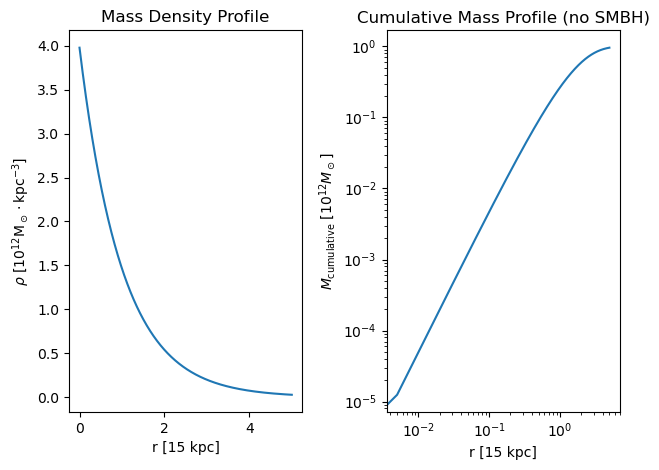

In [5]:
rho0 = M_tot / (4 * np.pi * z0 * R**2)

def rho(x, y, z):
    r = np.sqrt(x**2 + y**2)
    return rho0 * np.exp(-r / R) * np.exp(-abs(z) / z0)

def M_cumulative(r, m_smbh = None, r_smbh = None):
    if m_smbh is None or r_smbh is None:
        return M_tot * (1 - (1 + r / R) * np.exp(-r / R)) # the mass profile without the SMBH
    
    return m_smbh + M_cumulative(r) - M_cumulative(r_smbh)

def v_circular(r, m_cumul=None):
    if m_cumul is None:
        m_cumul = M_cumulative(r, M_smbh, R_smbh) # else, the user might want to provide the cumulative mass from the sample, that is not skewed!
    return np.sqrt(
        (G * m_cumul * r**2) / (r**2 + eps**2)**(3/2)
    )

r = np.linspace(0, 5*R, 1000)
z = np.linspace(-z0, z0, 1000)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(r, rho(r, 0, 0))
plt.xlabel('r [15 kpc]')
plt.ylabel(r'$\rho$ [$\rm 10^{12} M_\odot \cdot kpc^{-3}$]')
plt.title('Mass Density Profile')

plt.subplot(1, 2, 2)
plt.plot(r, M_cumulative(r))
plt.xlabel('r [15 kpc]')
plt.ylabel(r'$M_{\rm cumulative}$ [$10^{12} M_\odot$]')
plt.title('Cumulative Mass Profile (no SMBH)')
plt.yscale('log')
plt.xscale('log')

plt.tight_layout()
plt.show()

### 1.3. Random Sampling

Instead of using *Inverse Transform Sampling*, we choose *rejection sampling* because this might be easier. We randomly sample $r, z$ uniformly, sample them with probability proportionnal to $\rho(r,z)$.

Now, we need to compute this probability $P(r, z)$ :
$$
P(r) \propto \rho(r, z) / \rho_0 =  \exp \left(-\frac{r}{R_{MW}} \right) \exp \left(-\frac{|z|}{z_0} \right) 
$$
We normalize this expression in order to get:
$$
1 = \int_{r=0}^{\infty} \int_{z={-\infty}}^{\infty}P(r,z) 2 \pi r drdz
$$

We compute:
\begin{align}
N &= \int_{r=0}^{\infty} \int_{z={-\infty}}^{\infty} 2 \pi r drdz \exp \left(-\frac{r}{R_{MW}} \right) \exp \left(-\frac{|z|}{z_0} \right) \\
&= 4 \pi z_0 \int_{r=0}^{\infty}  \exp \left(-\frac{r}{R_{MW}} \right) r dr \\
&= 4 \pi z_0 R_{MW}^2
\end{align}

Thus:
$$
P(r,z) = \frac{1}{4 \pi z_0 R_{MW}^2} \exp \left(-\frac{r}{R_{MW}} \right) \exp \left(-\frac{|z|}{z_0} \right)
$$


In [6]:
def p(r, z = None): # here we include z to have the profile in exp(z/z0) as well
    if z is None:
        return 2 * z0 * p(r, 0) # this line is useless except for the following plot
    
    norm = 4 * np.pi * z0 * R**2
    return 1 / norm * rho(r, 0, z) / rho0


def sample_particles(n_part):
    sample = []
    n_sigmas = 10
    max_r = n_sigmas*R
    max_z = n_sigmas*z0
    while len(sample) < n_part:
        x = np.random.uniform(-max_r, max_r)
        y = np.random.uniform(-max_r, max_r)
        z = np.random.uniform(-max_z, max_z)
        r = np.sqrt(x**2 + y**2)
        
        # let's garantee elipsoidal symmetry
        if (x/max_r)**2 + (y/max_r)**2 + (z/max_z)**2 > 1:
            continue
        
        # let's put no particle in the SMBH
        if r < R_smbh:
            continue
        
        if np.random.uniform(0, 1) < p(r, z):
            sample.append((x, y, z))
    return np.array(sample)

sample = sample_particles(N_part - 1) # we add the black hole by hand later, exactly in the center

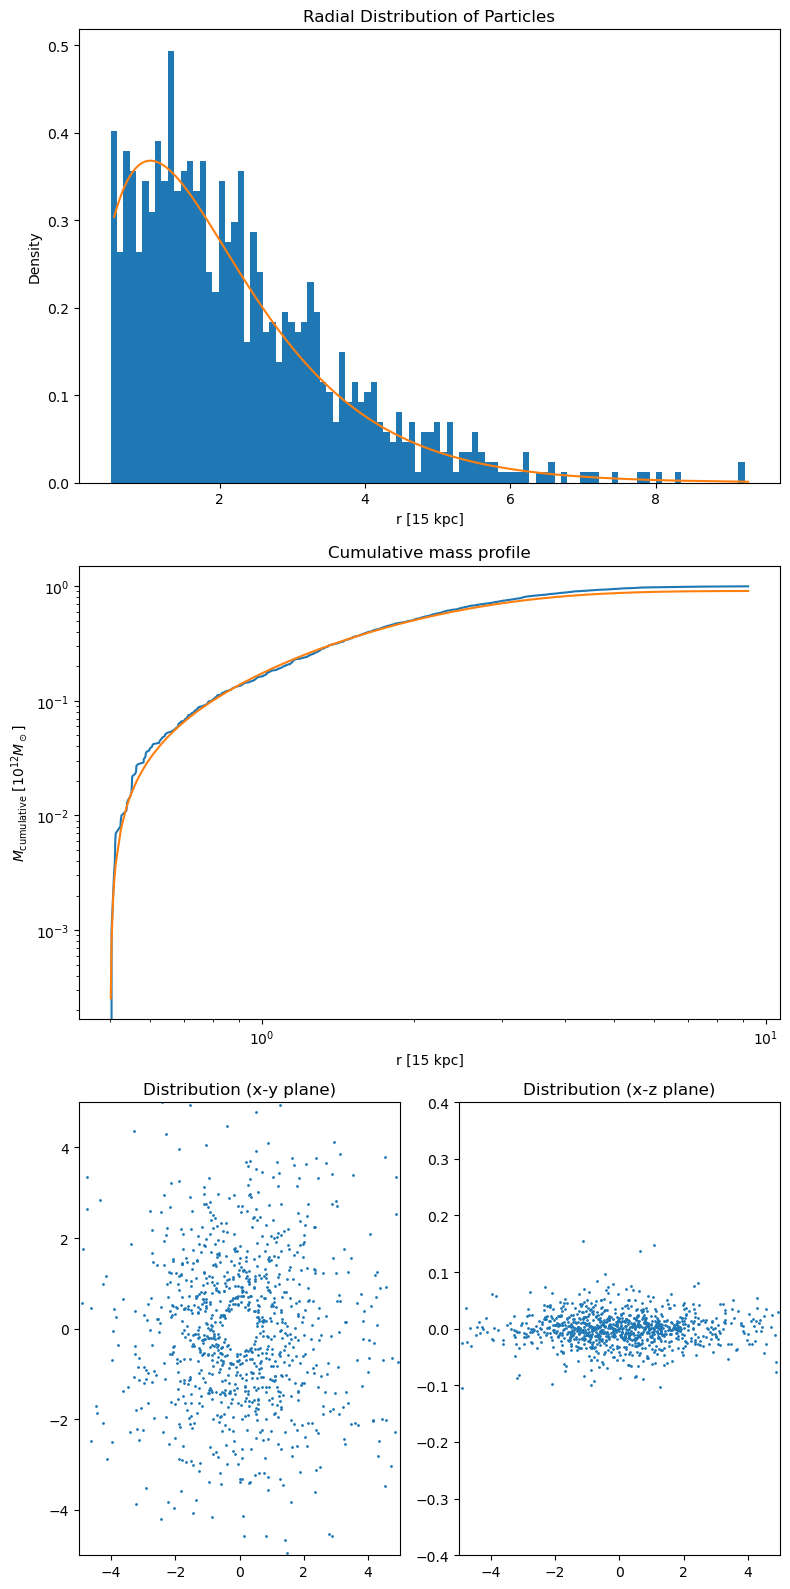

In [7]:
# let's check our distribution with histogram
# we compare rho(r) with the histogram of the radial distribution of the particles

r = np.array(sorted(np.sqrt(sample[:, 0]**2 + sample[:, 1]**2)))
expect_distribution = 2 * np.pi * r * p(r) # sum over the circle of radius r
N_bins = 100

plt.figure(figsize=(8, 16))
grid = GridSpec(3, 2)

plt.subplot(grid[0, :])
plt.hist(r, bins=N_bins, density=True, label="Particle distribution")
plt.plot(r + max(r)/N_bins/2, expect_distribution, label="Expected Distribution")
plt.xlabel('r [15 kpc]')
plt.ylabel('Density')
plt.title('Radial Distribution of Particles')

plt.subplot(grid[1, :])
plt.title("Cumulative mass profile")

# compute cumulative mass from our distribution
m_cumul = np.zeros_like(r)
for i in range(len(r)):
    #M[i] = m * (i + 1)
    m_cumul[i] = m * (i) # for the first particle, cumulative mass is 0 since no particle is inside the radius => i and not i+1

    
plt.plot(r, m_cumul, label='Sample Cumulative Mass')
plt.plot(r, M_cumulative(r) - M_cumulative(R_smbh), label='Expected Cumulative Mass')
plt.xlabel('r [15 kpc]')
plt.ylabel(r'$M_{\rm cumulative}$ [$10^{12} M_\odot$]')
plt.xscale('log')
plt.yscale('log')

plt.subplot(grid[2, 0])
plt.title("Distribution (x-y plane)")
plt.scatter(sample[:, 0], sample[:, 1], s=1)
plt.xlim(-5*R, 5*R)
plt.ylim(-5*R, 5*R)


plt.subplot(grid[2, 1])
plt.title("Distribution (x-z plane)")
plt.scatter(sample[:, 0], sample[:, 2], s=1)
plt.xlim(-5*R, 5*R)
plt.ylim(-20*z0, 20*z0)


plt.tight_layout()
plt.show()

For some reason that I don't understand, the cumulative mass profile is *off*, even if you increase the number of particles up to $10^5$ (more than that takes too long). Changin the sampling (espacially the ellipsoidal condition) donesn't change the result either. This is a very weird issue, and problematic for the computation of the circular velocity, that depends on it. In order to account for this difference, we won't use the theoretical cumulative mass distribution for the circular velocity, but the one of the sample.

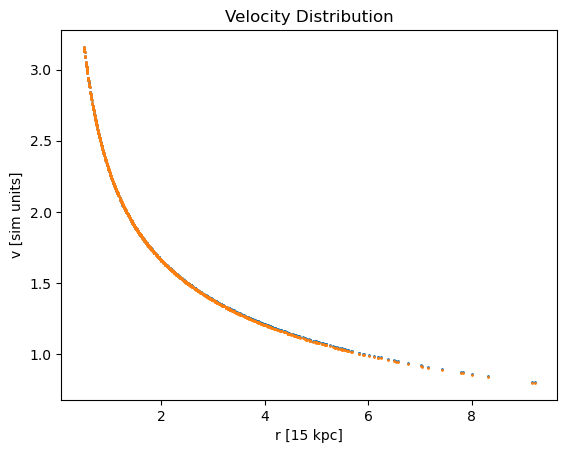

In [8]:
r = np.sqrt(sample[:, 0]**2 + sample[:, 1]**2) # this is 2d r, but anyway 2d r ~ 3d r since z0 << R

# we need to redefine m_cumul because the previous one was done on sorted array
m_cumul = np.zeros_like(r)
for i in range(len(r)):
    m_cumul[i] = m * np.sum(r < r[i])
    
# ADD SMBH
m_cumul += M_smbh

sample_velocities = v_circular(
    r, # maybe here r3d would be better, but it doesn't change anything in the end, the final issue remains even if z is set systematically to 0.
    m_cumul = m_cumul
)

df = pd.DataFrame(sample, columns=['x', 'y', 'z'])
df['v'] = sample_velocities 
df['r'] = r
df['m'] = m
df['eps'] = eps
df['phi'] = 0.0

# df['v'] is df['v_theta'] # let's compute vx vy vz accrodingly
theta = np.arctan2(df['y'], df['x'])
df['vx'] = -df['v'] * np.sin(theta)
df['vy'] = df['v'] * np.cos(theta)
df['vz'] = 0.0
df['v_theta'] = df['v'] # let's keep v_theta for later

df['v_circle'] = v_circular(df['r'])
df['v'] = np.sqrt(df['vx']**2 + df['vy']**2 + df['vz']**2)

plt.figure()
plt.scatter(df['r'], df['v'], s=1, label="Particle Velocities")
plt.scatter(df['r'], df['v_circle'], s=1, label="Circular Velocities")

plt.xlabel('r [15 kpc]')
plt.ylabel('v [sim units]')
plt.title('Velocity Distribution')
plt.show()

The velocity is about the same magnitude of the crossing time if $R=1$. This is expected, since $t_{cross} \approx \frac{R}{v}$. Theory and sample are different, however this is expected since one uses the theoretical cumulative mass distribution, and the other one uses the one of the sample, that is slightly different.

Now let's add the black hole!

In [9]:

# add the SMBH
smbh = [0, 0, 0, 0, 0, M_smbh, eps, 0, 0, 0, 0, 0, 0] # ['x', 'y', 'z', 'v', 'r', 'm', 'eps', 'phi', 'vx', 'vy', 'vz', 'v_theta', 'v_circle']

# insert it in first position
df_smbh = pd.concat([pd.DataFrame([smbh], columns=df.columns), df], ignore_index=True)
df_smbh.head()[['m', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'eps', 'phi']] # first row is the smbh!

,m,x,y,z,vx,vy,vz,eps,phi
0,5.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.01,0.0
1,0.001,0.257387,1.046320,0.008860,-2.131221,0.524265,0.0,0.01,0.0
2,0.001,0.088164,-1.082697,-0.008110,2.179092,0.177444,0.0,0.01,0.0
3,0.001,-3.260366,0.394124,-0.048028,-0.159402,-1.318645,0.0,0.01,0.0
4,0.001,0.271316,0.692431,-0.016735,-2.434312,0.953840,0.0,0.01,0.0


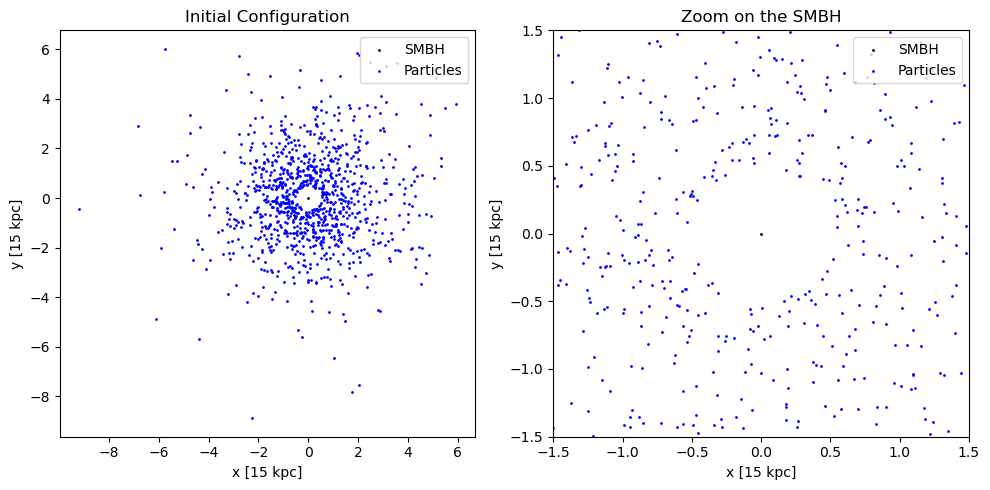

In [10]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(df_smbh['x'][0], df_smbh['y'][0], s=1, color='black', label='SMBH', zorder=10)
plt.scatter(df_smbh.loc[1:, 'x'], df_smbh.loc[1:, 'y'], s=1, color='blue', label='Particles')
plt.xlabel('x [15 kpc]')
plt.ylabel('y [15 kpc]')
plt.title('Initial Configuration')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title("Zoom on the SMBH")
plt.scatter(df_smbh['x'][0], df_smbh['y'][0], s=1, color='black', label='SMBH', zorder=10)
plt.scatter(df_smbh.loc[1:, 'x'], df_smbh.loc[1:, 'y'], s=1, color='blue', label='Particles')
plt.xlim(-R_smbh*3, R_smbh*3)
plt.ylim(-R_smbh*3, R_smbh*3)
plt.xlabel('x [15 kpc]')
plt.ylabel('y [15 kpc]')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### 1.4. Exporting to a file

We need to match the format of `data.txt`.

In [11]:
df_export = df_smbh[
    ["m", "x", "y", "z", "vx", "vy", "vz", "eps", "phi"]
]
df_export.to_csv("files/tests/galaxy/milkyway.txt", index=True, sep=" ", header=False)

And voilà!

___

### 2. Colliding galaxies

Let's create a second galaxy and make our galaxies collide!

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import os
while not os.path.exists('files'):
    os.chdir('..')
print("Current working directory:", os.getcwd())

In [ ]:
def create_galaxy(
    N_part,
    R,
    M_tot,
    M_smbh,
    R_smbh
):
    rho0 = M_tot / (4 * np.pi * z0 * R**2)
    z0 = 0.3 / 15 * R

    def rho(x, y, z):
        r = np.sqrt(x**2 + y**2)
        return rho0 * np.exp(-r / R) * np.exp(-abs(z) / z0)

    def M_cumulative(r, m_smbh = None, r_smbh = None):
        if m_smbh is None or r_smbh is None:
            return M_tot * (1 - (1 + r / R) * np.exp(-r / R))
        
        return m_smbh + M_cumulative(r) - M_cumulative(r_smbh)

    def v_circular(r, m_cumul=None):
        if m_cumul is None:
            m_cumul = M_cumulative(r, M_smbh, R_smbh)
        return np.sqrt(
            (G * m_cumul * r**2) / (r**2 + eps**2)**(3/2)
        )
        
    def p(r, z = None):
        if z is None:
            return 2 * z0 * p(r, 0)
        
        norm = 4 * np.pi * z0 * R**2
        return 1 / norm * rho(r, 0, z) / rho0


    def sample_particles(n_part):
        sample = []
        n_sigmas = 10
        max_r = n_sigmas*R
        max_z = n_sigmas*z0
        while len(sample) < n_part:
            x = np.random.uniform(-max_r, max_r)
            y = np.random.uniform(-max_r, max_r)
            z = np.random.uniform(-max_z, max_z)
            r = np.sqrt(x**2 + y**2)
            
            # let's garantee elipsoidal symmetry
            if (x/max_r)**2 + (y/max_r)**2 + (z/max_z)**2 > 1:
                continue
            
            # let's put no particle in the SMBH
            if r < R_smbh:
                continue
            
            if np.random.uniform(0, 1) < p(r, z):
                sample.append((x, y, z))
        return np.array(sample)
    
    sample = sample_particles(N_part - 1)

Let's take a look [here](../files/tests/galaxy/milkyway_over_time.gif)!